In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# List of DJIA tickers
djia_tickers = [
    "AAPL", "MSFT", "JPM", "JNJ", "WMT", "PG", "XOM", "V", "UNH", "INTC",
    "CSCO", "KO", "MRK", "BA", "DIS", "MCD", "IBM", "CVX", "GS", "NKE",
    "AXP", "CAT", "VZ", "MMM", "TRV", "HD", "RTX", "WBA", "DOW", "AMGN"
]

# Download daily adjusted closing prices
data = yf.download(djia_tickers, start="2018-01-01", end="2023-01-01")["Adj Close"]

# Calculate daily returns
returns = data.pct_change().dropna()


[*********************100%***********************]  30 of 30 completed


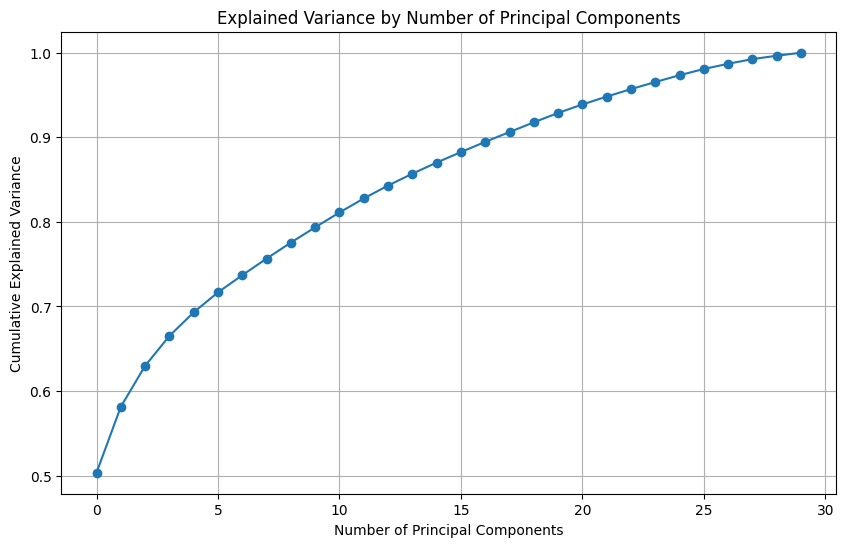

In [ ]:
# Standardize returns (mean = 0, variance = 1)
returns_std = (returns - returns.mean()) / returns.std()

# Initialize PCA
pca = PCA()
pca.fit(returns_std)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance to select the number of components
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Number of Principal Components")
plt.grid()
plt.show()


In [ ]:
# Select number of components explaining 80% of variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to explain 80% of variance: {n_components}")


Number of components to explain 80% of variance: 11


In [ ]:
# Refit PCA to obtain the first n_components eigen portfolios
pca = PCA(n_components=n_components)
pca.fit(returns_std)

# Extract eigen portfolio weights
eigen_portfolios = pd.DataFrame(
    pca.components_.T,
    index=returns.columns,
    columns=[f"Eigen Portfolio {i+1}" for i in range(n_components)]
)
eigen_portfolios.head()


,Eigen Portfolio 1,Eigen Portfolio 2,Eigen Portfolio 3,Eigen Portfolio 4,Eigen Portfolio 5,Eigen Portfolio 6,Eigen Portfolio 7,Eigen Portfolio 8,Eigen Portfolio 9,Eigen Portfolio 10,Eigen Portfolio 11
Ticker,,,,,,,,,,,
AAPL,0.179127,0.161460,0.363948,0.079125,0.205206,0.036504,0.063151,0.057684,-0.002432,0.015863,0.094277
AMGN,0.152055,0.276215,-0.148145,-0.016935,0.347821,-0.189836,-0.095451,-0.289148,-0.179611,0.122643,-0.187684
AXP,0.210866,-0.207464,0.063262,-0.117143,-0.079078,-0.070286,0.117574,-0.166428,-0.058835,0.107093,-0.097181
BA,0.172974,-0.248513,0.114632,-0.084208,-0.119972,0.043894,0.390904,-0.137525,-0.013209,-0.271689,0.030628
CAT,0.191063,-0.189330,-0.135838,0.253086,0.086106,-0.099975,-0.201067,0.072410,-0.141994,0.076502,0.039068


In [ ]:
# Calculate returns of each eigen portfolio
eigen_returns = returns_std.dot(eigen_portfolios)

# Calculate average return and risk (standard deviation)
eigen_avg_returns = eigen_returns.mean() * 252  # Annualize returns
eigen_risk = eigen_returns.std() * np.sqrt(252)  # Annualize risk

# Display eigen portfolio returns and risks
eigen_performance = pd.DataFrame({
    "Eigen Portfolio": eigen_avg_returns.index,
    "Annualized Return": eigen_avg_returns.values,
    "Annualized Risk": eigen_risk.values
})
print(eigen_performance)


       Eigen Portfolio  Annualized Return  Annualized Risk
0    Eigen Portfolio 1      -4.721590e-15        61.695253
1    Eigen Portfolio 2       7.918194e-15        24.270556
2    Eigen Portfolio 3       1.343160e-14        19.127751
3    Eigen Portfolio 4       2.881343e-15        16.358574
4    Eigen Portfolio 5       5.396103e-15        14.519480
5    Eigen Portfolio 6       3.027976e-15        13.366384
6    Eigen Portfolio 7      -4.047077e-15        12.385268
7    Eigen Portfolio 8       3.918773e-15        12.180800
8    Eigen Portfolio 9       4.567625e-15        11.955196
9   Eigen Portfolio 10       2.316805e-15        11.694805
10  Eigen Portfolio 11       3.695157e-15        11.500081


In [ ]:
# Calculate daily mean returns and covariance matrix
mean_returns = returns.mean()  # Daily mean returns of each asset
cov_matrix = returns.cov()     # Covariance matrix of returns


In [ ]:
# Example: Equal allocation across all eigen portfolios for diversification
portfolio_weights = eigen_portfolios.mean(axis=1)

# Normalize to sum to 1
portfolio_weights /= portfolio_weights.sum()

# Portfolio performance calculation
portfolio_return = np.sum(portfolio_weights * mean_returns) * 252  # Annualized
portfolio_risk = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix * 252, portfolio_weights)))  # Annualized
sharpe_ratio = (portfolio_return - 0.01) / portfolio_risk  # Assume 1% risk-free rate

print(f"Expected Portfolio Return: {portfolio_return:.2%}")
print(f"Portfolio Volatility (Risk): {portfolio_risk:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Expected Portfolio Return: 11.10%
Portfolio Volatility (Risk): 26.91%
Sharpe Ratio: 0.38


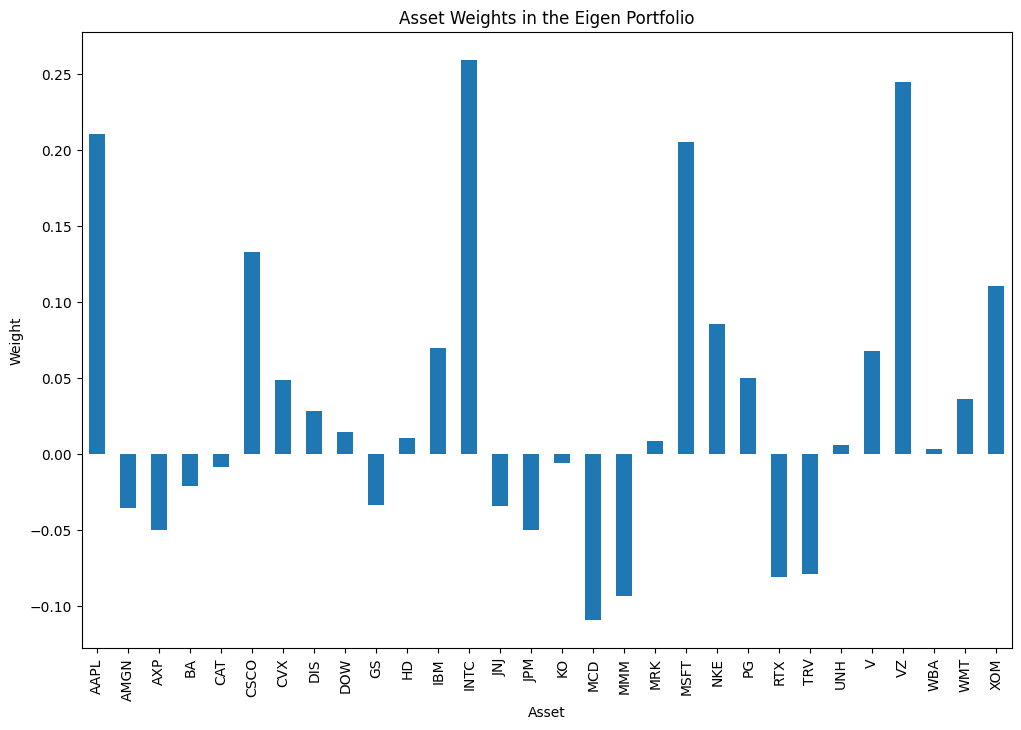

In [ ]:
# Plot portfolio weights
plt.figure(figsize=(12, 8))
portfolio_weights.plot(kind="bar")
plt.title("Asset Weights in the Eigen Portfolio")
plt.ylabel("Weight")
plt.xlabel("Asset")
plt.show()


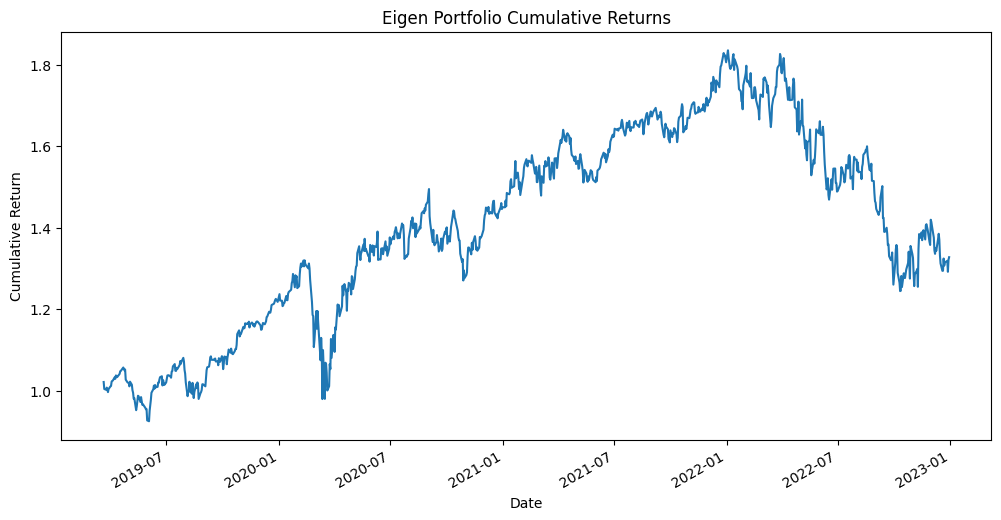

In [ ]:
# Calculate portfolio cumulative returns for the chosen allocation
cumulative_returns = (returns.dot(portfolio_weights) + 1).cumprod()
cumulative_returns.plot(figsize=(12, 6), title="Eigen Portfolio Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()
